# COMP47590 Advanced Machine Learning
# CNNs in Keras

This notebook demontates how  a convoluional neural network can be trained to recognise hand written digits, which is imporant for many AI systems, for exmaple automated check recognition. This example is based on [https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)

Import packages that will be used in this demo. 

In [58]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import gradio as gr

import random
import scipy as sp
import PIL
import os
import cv2

from IPython.display import display, HTML, Image
from IPython.display import SVG

from sklearn import preprocessing 
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import model_to_dot

tensorflow.keras.backend.set_image_data_format('channels_last')

## Dataset Pre-Processing

Read in the mnist dataset and prepare it for learning. This noramlises the values to between 0 and 1, and divides the data into Train, Validation and Test sets. 

In [29]:
abt = pd.read_csv("mnist_train.csv", encoding = "ISO-8859-1")

# Make a random sample from the full dataset
sample_rate = 0.5
abt = abt.sample(frac = sample_rate)

# Put all but the target variable into the descriptive features array
X = abt.iloc[:, 1:]
Y = abt["label"]

# Use a range scaling to scale all variables to between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
cols = X.columns
X = pd.DataFrame(min_max_scaler.fit_transform(X), columns = cols) # Watch out for putting back in columns here

# Perfrom split to train, validation, test
x_train_plus_valid, x_test, y_train_plus_valid, y_test = train_test_split(X, Y, random_state=0, test_size = 0.30, train_size = 0.7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.199/0.7, train_size = 0.5/0.7)

# convert to numpy arrays
x_train = x_train.values
x_valid = x_valid.values
x_test = x_test.values

y_train_cat = y_train.copy()
y_valid_cat = y_valid.copy()
y_test_cat = y_test.copy()

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [24]:
abt.head()

,label,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739
39385,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28837,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53829,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27273,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
abt.shape

(30000, 785)

Prepare the data for input to a convolutional network

In [30]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'valid samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_valid = tensorflow.keras.utils.to_categorical(y_valid, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (15000, 28, 28, 1)
15000 train samples
5971 valid samples
9000 test samples


Print some images from the training set

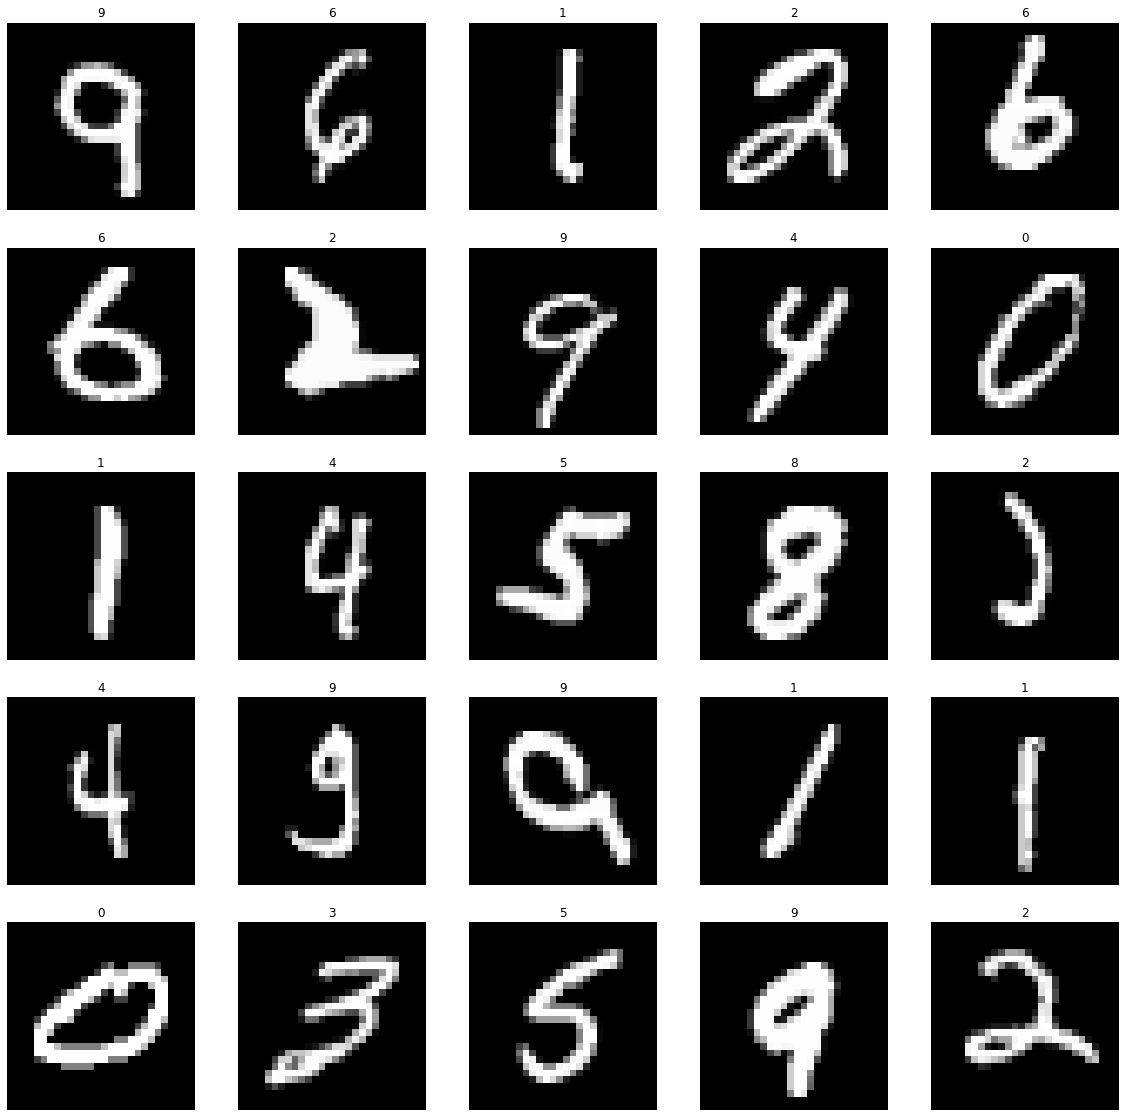

In [32]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, x_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((x_train[i_rand]*255).astype('int').reshape(28,28), cmap='gray', vmin=0, vmax=255)
    plt.title((str(y_train_cat.iloc[i_rand])))
    # print('Training sample',i_rand,': class:',y_train[i_rand])

## Model Building

Set up the convolutional neural network.

In [33]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, kernel_size=(3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1000))
model.add(Activation("relu"))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 activation_3 (Activation)   (None, 26, 26, 8)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 activation_4 (Activation)   (None, 11, 11, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                  

Train the model

In [34]:
batch_size = 128
epochs = 30

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid))

Epoch 1/30
118/118 [==============================] - 5s 37ms/step - loss: 0.5327 - accuracy: 0.8533 - val_loss: 0.2158 - val_accuracy: 0.9320
Epoch 2/30
118/118 [==============================] - 4s 33ms/step - loss: 0.1554 - accuracy: 0.9541 - val_loss: 0.1305 - val_accuracy: 0.9603
Epoch 3/30
118/118 [==============================] - 4s 38ms/step - loss: 0.1094 - accuracy: 0.9661 - val_loss: 0.0966 - val_accuracy: 0.9714
Epoch 4/30
118/118 [==============================] - 4s 37ms/step - loss: 0.0791 - accuracy: 0.9760 - val_loss: 0.0875 - val_accuracy: 0.9737
Epoch 5/30
118/118 [==============================] - 4s 35ms/step - loss: 0.0615 - accuracy: 0.9796 - val_loss: 0.0740 - val_accuracy: 0.9791
Epoch 6/30
118/118 [==============================] - 4s 38ms/step - loss: 0.0520 - accuracy: 0.9845 - val_loss: 0.0782 - val_accuracy: 0.9762
Epoch 7/30
118/118 [==============================] - 5s 40ms/step - loss: 0.0438 - accuracy: 0.9859 - val_loss: 0.0680 - val_accuracy: 0.9789

Plot accuracy and loss over the training period for training and validation sets.

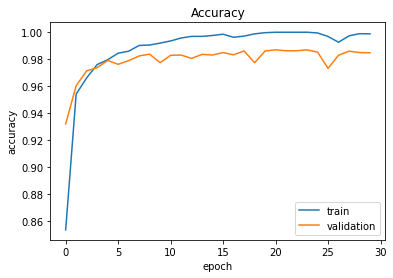

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylim((-0.1, 1.1))
plt.show()

In [37]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07434952259063721
Test accuracy: 0.983222246170044


## Model Evaluation

Evaluate the model

In [38]:
from sklearn import metrics
print("****** Test Data ********")

# Make a set of predictions for the validation data
y_pred = model.predict(np.asfarray(x_test))
y_pred = np.argmax(y_pred,axis=1)

# Print performance details
print(metrics.classification_report(y_test_cat, y_pred))

# Print confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_test_cat, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

****** Test Data ********
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       879
           1       0.99      0.99      0.99       998
           2       0.97      0.99      0.98       918
           3       0.99      0.98      0.98       919
           4       0.99      0.97      0.98       883
           5       0.99      0.98      0.98       855
           6       0.99      0.99      0.99       861
           7       0.97      0.99      0.98       963
           8       0.98      0.97      0.98       864
           9       0.97      0.98      0.98       860

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,872,3,0,0,0,0,2,1,1,0,879
1,0,987,3,0,0,0,0,6,1,1,998
2,3,2,905,3,1,0,0,4,0,0,918
3,1,0,11,897,0,3,0,3,2,2,919
4,0,4,1,0,858,0,4,3,3,10,883
5,1,0,0,3,0,838,2,2,8,1,855
6,1,0,2,0,4,1,853,0,0,0,861
7,0,2,5,0,0,1,0,953,0,2,963
8,0,3,2,3,0,5,3,3,839,6,864


Plot some of the examples that the model classified correctly.

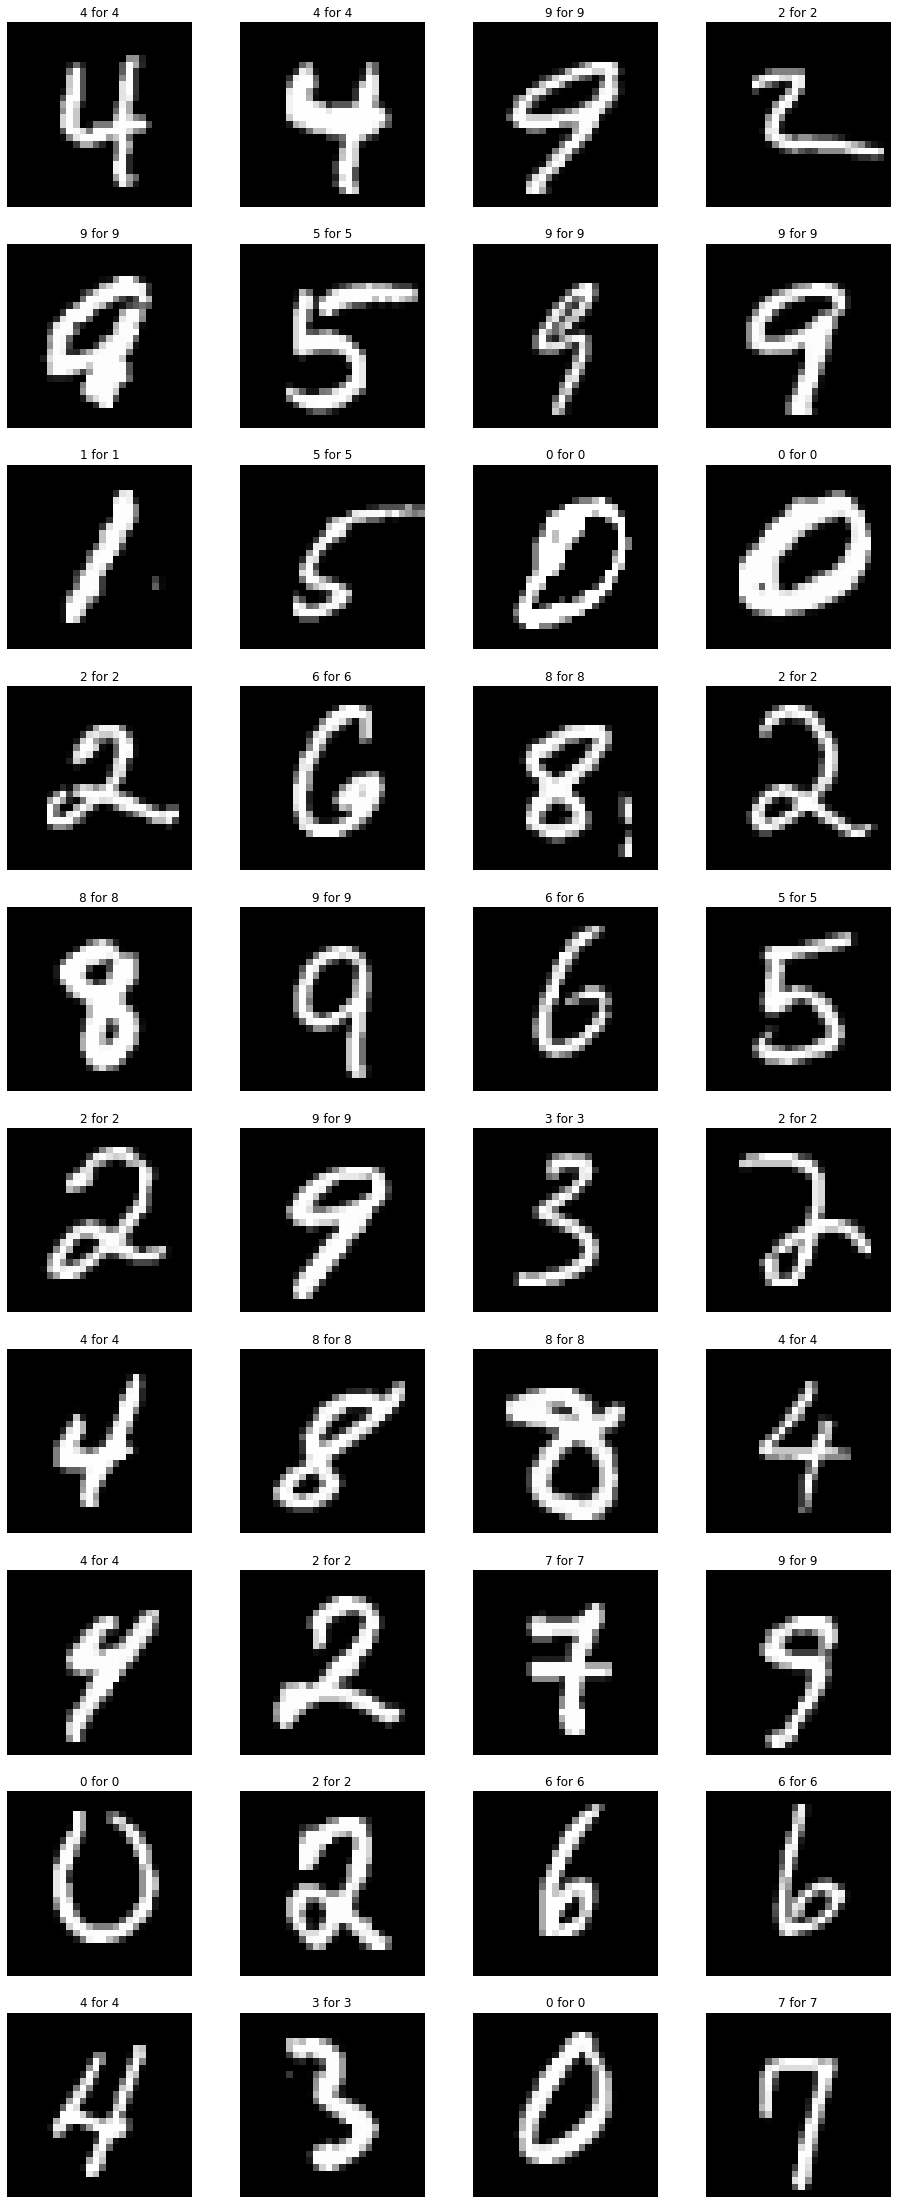

In [39]:
pltsize=4
row_images = 10
col_images = 4

maxtoshow = row_images * col_images
predictions = y_pred.reshape(-1)
corrects = predictions == y_test_cat
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects.iloc[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow((x_test[i]*255).astype('int').reshape(28,28), cmap='gray', vmin=0, vmax=255)
        plt.title("{} for {}".format(predictions[i], y_test_cat.iloc[i]))
        ii = ii + 1

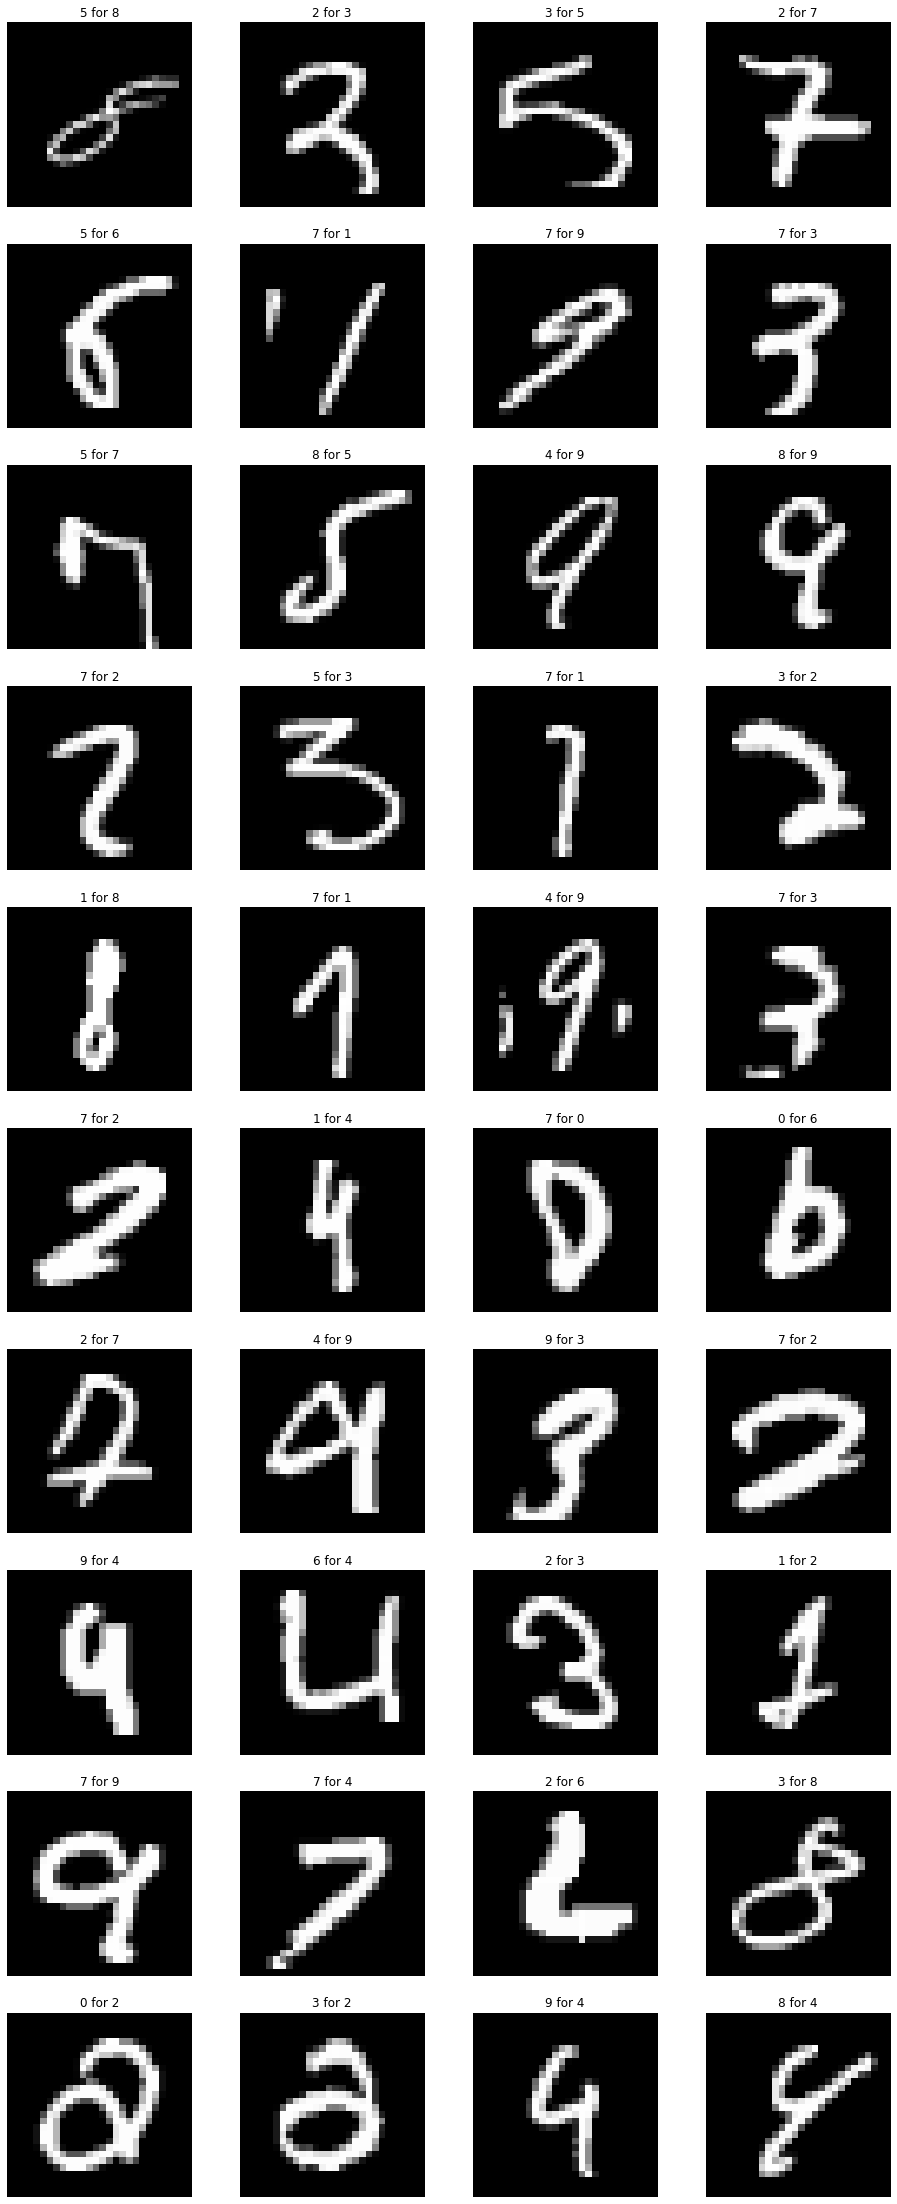

In [40]:
pltsize=4
row_images = 10
col_images = 4

maxtoshow = row_images * col_images
predictions = y_pred.reshape(-1)
errors = predictions != y_test_cat
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors.iloc[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow((x_test[i]*255).astype('int').reshape(28,28), cmap='gray', vmin=0, vmax=255)
        plt.title("{} for {}".format(predictions[i], y_test_cat.iloc[i]))
        ii = ii + 1

## Deploy the Model!

Load test images from a test folder and make predictions for them. 

In [49]:
image_class_folder = "./test_images/"

# generate filenames from the data folder and do sampling
image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not (i.startswith('.') or i.startswith('Icon')) ] 

# Create a data array for image data
count = len(image_filenames)
X_data_test = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):

    # Low the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
    image = image.reshape(28,28,1)

    # Add image data to data array and normalise
    X_data_test[i] = image
    X_data_test[i] = X_data_test[i]/255

    if i > 0 and i%100 == 0: print('Processed {} of {} '.format(i, count))

print('Processed {} of {} '.format(i, count))

Processed 16 of 17 


/var/folders/bz/lbfg_nj54wd40pqchhwx6ys80000gp/T/ipykernel_51639/3262147649.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_data_test = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)


In [50]:
X_data_test[9].max()

0.0

Make a set of predictions for the images loaded.

In [51]:
y_pred = model.predict(np.asfarray(X_data_test))
y_pred = np.argmax(y_pred,axis=1)

In [52]:
y_pred_acc = model.predict(np.asfarray(X_data_test))

In [53]:
pd.DataFrame(y_pred_acc)

,0,1,2,3,4,5,6,7,8,9
0,2.191857e-03,8.329812e-09,2.986043e-08,2.566960e-04,2.002365e-08,8.125136e-05,9.974693e-01,1.226957e-08,9.179901e-07,4.179963e-08
1,5.565416e-15,2.448927e-13,2.337120e-10,1.000000e+00,1.318748e-17,2.569519e-10,3.187627e-19,3.032178e-12,5.434724e-10,8.860301e-09
2,1.000000e+00,9.755763e-16,2.196042e-09,2.119875e-17,4.079209e-22,5.676019e-11,4.776969e-12,5.040833e-14,1.349066e-14,3.362985e-09
3,2.274709e-09,5.119972e-08,9.999934e-01,8.479713e-09,7.300370e-20,8.889470e-18,2.541485e-21,6.545723e-06,3.444446e-13,2.273933e-12
4,2.599439e-08,6.288651e-09,1.956388e-04,9.994226e-01,4.543586e-14,1.203848e-05,8.549465e-11,2.437801e-06,3.613286e-04,6.093133e-06
5,2.221183e-05,9.989251e-01,2.200871e-07,4.458157e-16,1.048817e-03,3.728325e-10,1.083134e-06,7.079245e-07,1.756922e-06,1.161995e-09
6,2.374019e-11,5.152060e-12,7.980150e-09,2.316756e-08,9.999964e-01,2.711817e-09,9.187379e-08,9.503764e-12,3.086763e-11,3.426710e-06
7,3.831845e-15,9.609947e-12,2.200373e-07,2.992358e-09,5.490127e-09,9.999169e-01,2.731252e-07,1.033067e-08,8.264428e-05,5.672769e-10
8,4.459460e-05,7.413438e-04,1.657070e-03,3.306504e-11,3.375662e-03,1.216053e-09,9.941813e-01,2.692946e-11,3.311693e-10,1.374724e-12
9,9.976231e-02,1.453970e-01,9.520067e-02,8.473812e-02,9.782449e-02,1.015754e-01,9.205496e-02,1.186613e-01,6.759043e-02,9.719531e-02


Draw the images and the predictions made by the model.

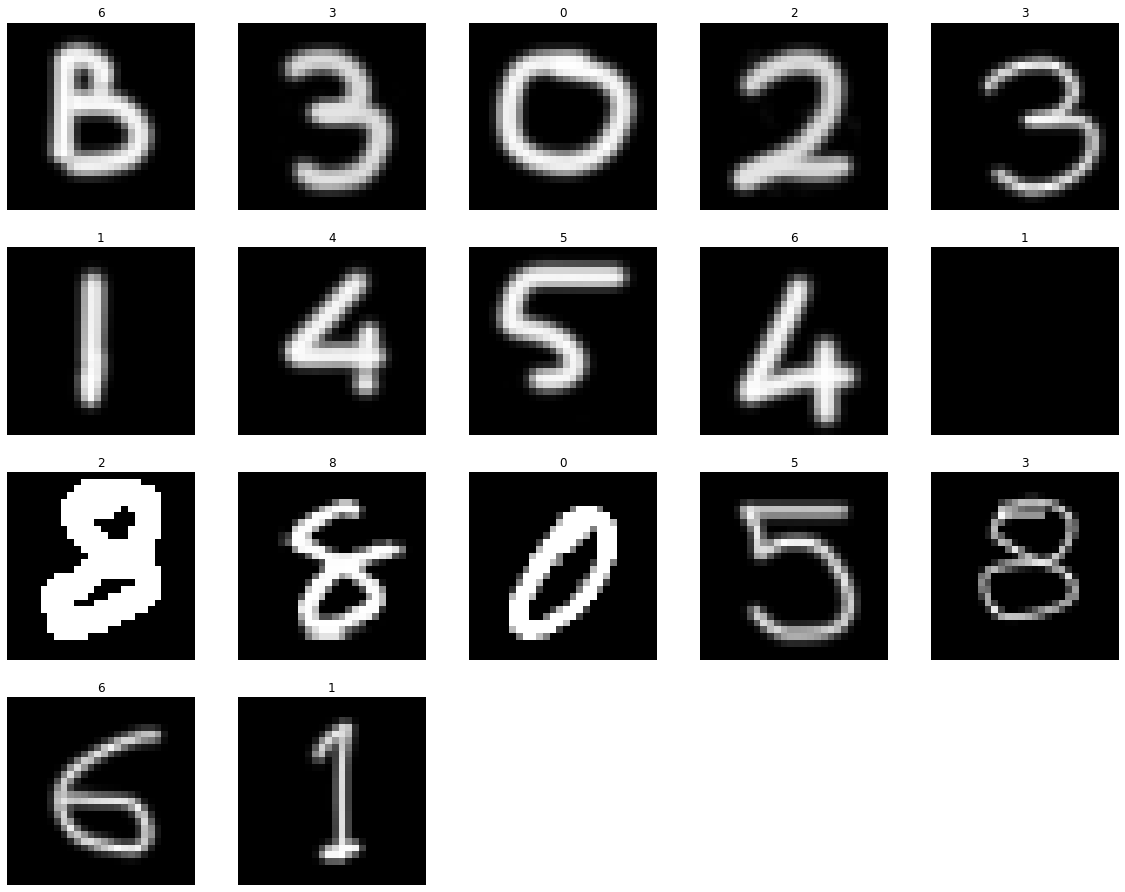

In [54]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    if(i == len(X_data_test)):
        break
        
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X_data_test[i]*255).astype('int').reshape(28,28), cmap='gray', vmin=0, vmax=255)
    plt.title("{}".format(y_pred[i]))    


Start an interactive version (using gradio)

In [64]:
def recognize_digit(image):
    image = image.reshape(1, 28, 28, 1)
    prediction = model.predict(image).tolist()[0]
    return {str(i): prediction[i] for i in range(10)}

im = gradio.inputs.Image(shape=(28, 28), 
                         image_mode='L', 
                         invert_colors=True, 
                         source="canvas")

iface = gr.Interface(
    recognize_digit, 
    im, 
    gradio.outputs.Label(num_top_classes=3),
    live=True,
    interpretation="default",
    capture_session=True,
)

iface.test_launch()

/Users/bmacnamee/opt/anaconda3/envs/RL_Jan_2021/lib/python3.9/site-packages/gradio/interface.py:188: UserWarning: The `capture_session` parameter in the `Interface` is deprecated and has no effect.
  warnings.warn("The `capture_session` parameter in the `Interface` is deprecated and has no effect.")


Test launch: recognize_digit()... PASSED


In [65]:
iface.launch()

Running on local URL:  http://127.0.0.1:7862/

To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7862/', None)